/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
70240/70240 ━━━━━━━━━━━━━━━━━━━━ 579s 8ms/step - loss: 3.5976e-10
Epoch 2/10
70240/70240 ━━━━━━━━━━━━━━━━━━━━ 570s 8ms/step - loss: 4.0785e-11
Epoch 3/10
70240/70240 ━━━━━━━━━━━━━━━━━━━━ 624s 8ms/step - loss: 3.5533e-11
Epoch 4/10
70240/70240 ━━━━━━━━━━━━━━━━━━━━ 627s 8ms/step - loss: 3.2890e-11
Epoch 5/10
70240/70240 ━━━━━━━━━━━━━━━━━━━━ 579s 8ms/step - loss: 3.1381e-11
Epoch 6/10
70240/70240 ━━━━━━━━━━━━━━━━━━━━ 621s 8ms/step - loss: 3.0067e-11
Epoch 7/10
70240/70240 ━━━━━━━━━━━━━━━━━━━━ 621s 8ms/step - loss: 2.9236e-11
Epoch 8/10
70240/70240 ━━━━━━━━━━━━━━━━━━━━ 629s 8ms/step - loss: 2.8563e-11
Epoch 9/10
70240/70240 ━━━━━━━━━━━━━━━━━━━━ 617s 8ms/step - loss: 2.7979e-11
Epoch 10/10
70240/70240 ━━━━━━━━━━━━━━━━━━━━ 625s 8ms/step - loss: 2.7633e-11
13359/13359 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step
Mean Squared Error on Test Data: 272000.72911971126


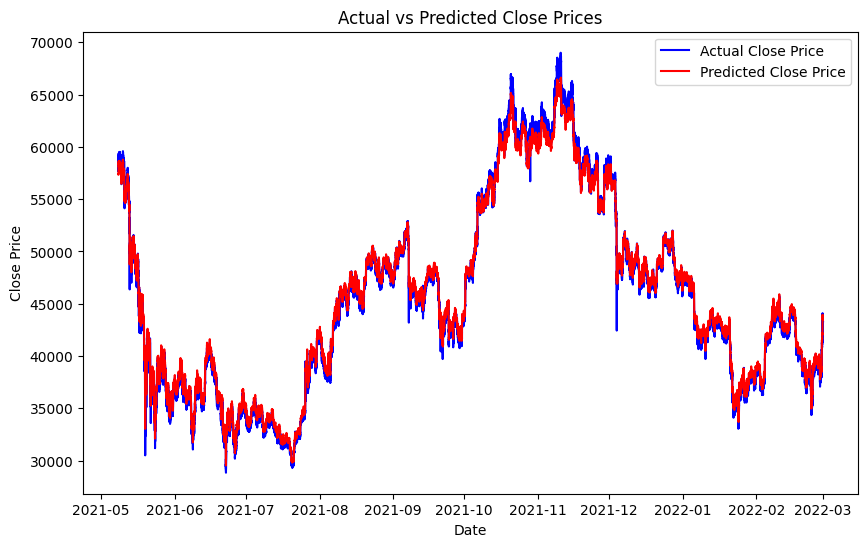

In [1]:
import gym
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ----------------------------------------
# Step 1: LSTM Model Development
# ----------------------------------------

# Load and preprocess the training data
train_data = pd.read_csv('train_data.csv', parse_dates=['date'], index_col='date')

# Data Preprocessing (Adding EWMA and Rolling Mean)
train_data['EWMA'] = train_data['close'].ewm(span=20, adjust=False).mean()  # Exponentially Weighted Moving Average
train_data['Rolling_Mean'] = train_data['close'].rolling(window=20).mean()  # Simple Moving Average
train_data['Returns'] = train_data['close'].pct_change()  # Calculate returns
train_data['Returns'] = train_data['Returns'] * 1000  # Scale returns
train_data.dropna(inplace=True)  # Drop NaNs caused by rolling and returns calculations

# Prepare Data for LSTM
features = train_data[['close', 'EWMA', 'Rolling_Mean']].dropna()
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Prepare LSTM inputs (using past 60 days to predict the next day's price)
def create_lstm_data(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])  # Use past 'time_steps' days as input
        y.append(data[i, 0])  # Predict the next day's close price
    return np.array(X), np.array(y)

X_train, y_train = create_lstm_data(scaled_features)

# Create weights based on date recency: more weight for recent data
# Normalize weights such that the most recent data gets the highest weight
date_weights = np.arange(len(y_train), 0, -1)  # Higher weight for recent dates
weights = date_weights / date_weights.sum()  # Normalize weights

# Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for price prediction

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM Model with sample weights
model.fit(X_train, y_train, epochs=10, batch_size=32, sample_weight=weights)

# Load and preprocess the test data
test_data = pd.read_csv('test_data.csv', parse_dates=['date'], index_col='date')
test_data['EWMA'] = test_data['close'].ewm(span=20, adjust=False).mean()
test_data['Rolling_Mean'] = test_data['close'].rolling(window=20).mean()
test_data['Returns'] = test_data['close'].pct_change()
test_data.dropna(inplace=True)

# Prepare Test Data for LSTM Prediction
test_features = test_data[['close', 'EWMA', 'Rolling_Mean']].dropna()
scaled_test_features = scaler.transform(test_features)

X_test, _ = create_lstm_data(scaled_test_features)

# Make Predictions on Test Data
predicted_close_prices = model.predict(X_test)
predicted_close_prices = scaler.inverse_transform(np.concatenate([predicted_close_prices,
                                                                  scaled_test_features[-len(predicted_close_prices):, 1:]], axis=1))[:, 0]

# Add predictions to test data
test_data['Predicted_Close'] = np.nan
test_data.iloc[-len(predicted_close_prices):, test_data.columns.get_loc('Predicted_Close')] = predicted_close_prices

# Align data for MSE calculation
aligned_test_data = test_data[['close', 'Predicted_Close']].dropna()
mse = mean_squared_error(aligned_test_data['close'], aligned_test_data['Predicted_Close'])
print(f"Mean Squared Error on Test Data: {mse}")

# Visualize the Predictions
plt.figure(figsize=(10, 6))
plt.plot(aligned_test_data['close'], label='Actual Close Price', color='blue')
plt.plot(aligned_test_data['Predicted_Close'], label='Predicted Close Price', color='red')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
